In [1]:
import heeps
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.pupil.create_lyotstop import create_ls
from heeps.util.img_processing import resize_img, pad_img, crop_img, oversamp
from heeps.util.round2odd import round2odd
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper.prop_get_amplitude as get_amplitude
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import warnings
%matplotlib inline

### Inputs

In [2]:
pupil_img_size = 39.9988    # pupil image in m
nimg = 10526                # size of the high-res pupil image
print('pupil_img_size = %s m'%pupil_img_size)
print('nimg = %s'%nimg)
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# RA optimal diameter
diam_ravc_opt = 18.637 # (r_opt=0.505)
# spider width in m
spi_width = 0.54
# METIS "pupil image" size in mm
pupil_img_size_METIS = {'IMG': 45/diam_nominal_ext*pupil_img_size, 
                        'LMS': 28/diam_nominal_ext*pupil_img_size}
print('pupil_img_size_METIS = %s mm'%dict((x, round(y, 2)) 
    for x, y in pupil_img_size_METIS.items()))
# Huygens PSF data
dir_data = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/pupil_blurring/data'))
data_spacing = 0.014239     # in mm
npup_conv = dict((x, int(np.ceil(y/data_spacing))) 
    for x, y in pupil_img_size_METIS.items())
print('npup_conv = %s'%npup_conv)
# parameters at each band
phot_spiders = {'L' :3.5,   # pixels on the spiders (for 1 inside the pupil)
                'N2':4.3}
phot_envirnt = {'L' :4.3,   # pixels outside the pupil (for 1 inside the pupil)
                'N2':5.1}
npupil = {'L': update_config(**dict(read_config(), band='L'))['npupil'],
          'N2':update_config(**dict(read_config(), band='N2'))['npupil']}
pupil_scaling = 4
print('npupil = %s'%npupil)
print('pupil_scaling = %s'%pupil_scaling)
title_bkg = 'Relative additionnal flux from blurred background\n(sweetspot %s)'
title_vpm = 'Relative additionnal VPM leakage from blurred pupil\n(sweetspot %s)'
title_vpm2 = 'VPM leakage from blurred pupil\n(sweetspot %s)'
title_app = 'APP blurred pupil flux uniformity/peak-to-valley\n(sweetspot %s)'

pupil_img_size = 39.9988 m
nimg = 10526
pupil_img_size_METIS = {'IMG': 46.7, 'LMS': 29.06} mm
npup_conv = {'IMG': 3280, 'LMS': 2041}
npupil = {'L': 285, 'N2': 119}
pupil_scaling = 4


### Create pupils

In [3]:
eso = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil/eso'))
maskM1 = fits.getdata(os.path.join(eso, 'mask_fullM1.fits'))
spiders = fits.getdata(os.path.join(eso, 'SpiderShadow.fits'))
pickle_M1 = os.path.join(eso, 'data_spacing_%s/pup_M1.pkl'%data_spacing)
if os.path.isfile(pickle_M1):
    pup_M1 = pickle.load(open(pickle_M1,'rb'))
else:
    pup_M1 = dict((x, resize_img(maskM1*spiders, y))
                for x, y in npup_conv.items())
    with open(pickle_M1, 'wb') as file:
        pickle.dump(pup_M1, file)
        file.close()
pickle_bkg = os.path.join(eso, 'data_spacing_%s/pup_bkg.pkl'%data_spacing)
if os.path.isfile(pickle_bkg):
    pup_bkg = pickle.load(open(pickle_bkg,'rb'))
else:
    pup_bkg = dict((x, dict((band, resize_img(maskM1*((1 - spiders)*phot_spi) 
                    + (1 - maskM1)*phot_env, y)) 
                    for (band, phot_spi), (band, phot_env) 
                    in zip(phot_spiders.items(), phot_envirnt.items())))
                for x, y in npup_conv.items())
    with open(pickle_bkg, 'wb') as file:
        pickle.dump(pup_bkg, file)
        file.close()

### Define functions

In [4]:
def conv_pupil(conf, plane, data, i, pupil_scaling=pupil_scaling):
    band = conf['band']
    filename = conf['dir_output'] + 'data_%s_kernel.fits'%i
    if os.path.isfile(filename):
        kernel = fits.getdata(conf['dir_output'] + 'data_%s_kernel.fits'%i)
        pup_bkg_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i)
        pup_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_conv.fits'%i)
        kernel_vpm = fits.getdata(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i)
        pup_vpm = fits.getdata(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i)
        nkernel = kernel.shape[0]
        nkernel_vpm = kernel_vpm.shape[0]
        npup_vpm = pup_vpm.shape[0]
    else:
        # 1/ load kernel (Huygens PSF)
        kernel = np.loadtxt(data%i, delimiter='\t', encoding='utf-16', skiprows=21)
        kernel = np.delete(kernel, 0, 0)
        kernel = np.delete(kernel, 0, 1)
        nkernel = kernel.shape[0]
        # 2/ convolve background thermal emission with kernel
        filename = conf['dir_output'] + 'data_%s_blurred_bkg.fits'%i
        pup_bkg_conv = astroconv.convolve(pup_bkg[plane][band], kernel, boundary='extend')
        # 3/ convolve M1 pupil with kernel
        pup_conv = astroconv.convolve(pup_M1[plane], kernel, boundary='extend')
        # 4/ resample kernel
        nkernel_vpm = round2odd(nkernel*pupil_scaling*npupil[band]/npup_conv[plane])
        npup_vpm = npup_conv[plane]*nkernel_vpm/nkernel
        npad, npup_vpm = oversamp(nimg, npup_vpm, precision=1e-2)
        kernel_vpm = resize_img(kernel, nkernel_vpm)
        pup_vpm = resize_img(pad_img(maskM1*spiders, npad), npup_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel.fits'%i, kernel)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i, pup_bkg_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_conv.fits'%i, pup_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i, kernel_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i, pup_vpm)
    pupil_img_size_scaled = pup_vpm.shape[0]*pupil_img_size/(pupil_scaling*npupil[band])
    print('background:')
    print('   nkernel = %s, npup_conv = %s (%s)'%(nkernel, npup_conv[plane], plane))
    print('HCI:')
    print('   nkernel_vpm = %s, npup_vpm = %s\n'%(nkernel_vpm, npup_vpm))
    # 5/ figure
    c = pup_conv.shape[0]/2
    cext = c/pupil_img_size*diam_allglass_ext
    cint = c/pupil_img_size*diam_allglass_int
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.1, 1, 1])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.subplot(gs[0]); plt.title('kernel (log10)')
        plt.imshow(np.log10(kernel), origin='lower', cmap='inferno')
        plt.colorbar(cax=fig.add_axes([0.33, 0.17, 0.01, 0.65]))
        vmin, vmax = -1, 1 #log10
        plt.subplot(gs[2]); plt.title('blurred background (log10)')
        plt.imshow(np.log10(pup_bkg_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[2].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[2].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
        plt.subplot(gs[3]); plt.title('blurred pupil (log10)')
        plt.imshow(np.log10(pup_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[3].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[3].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
    plt.colorbar(cax=fig.add_axes([0.85, 0.17, 0.01, 0.65]))
    plt.subplots_adjust(right=0.84) # for colorbar
    plt.savefig(conf['dir_output'] + 'data_%s_blurring.png'%i, dpi=300, transparent=True)
    return pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled

def cold_stop(conf, r_pup, r_spi, circ_int=False, dRint=0.08):
    # RAVC case (circ_int set to True)
    diam_int = diam_ravc_opt if circ_int == True else diam_allglass_int
    # CVC case (ls_dRint set to None)
    dRint = dRint if conf['ls_dRint'] is None else r_pup
    # create cold stop
    cs = create_ls(diam_allglass_ext, diam_int, dRext=r_pup, dRint=dRint, dRspi=r_spi,
                    circ_ext=False, circ_int=circ_int, **conf)
    return cs

def get_blur_sharp(conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2, r_pup, r_spi):
    # flux from sharp background
    cs = cold_stop(conf, r_pup, r_spi)
    bkg_sharp = np.sum(cs)
    # relative flux from blurred background
    bkg_blur = np.sum(cs*pup_bkg_conv)/bkg_sharp
    # HCI case
    I_blur, I_sharp = 0, 0
    if 'VC' in conf['mode']:
        if 'CVC' in conf['mode']:
            conf_vpm['ls_dRint'] = None
        # flux from sharp pupil
        cs_vpm = cold_stop(conf_vpm, r_pup, r_spi, circ_int=('RAVC' in conf['mode']))
        hci_sharp = np.sum(cs_vpm)
        # sharp leakage
        I_sharp = np.sum((cs_vpm*amp1)**2)
        # blurred leakage
        I_blur = np.sum((cs_vpm*amp2)**2)
        # relative leakage from blurred pupil
        hci_blur = (I_blur/I_sharp) - 1
    elif 'APP' in conf['mode']:
        # p2v flux from blurred pupil
        hci_sharp = bkg_sharp
        hci_blur = np.round(cs).astype(int)*pup_conv
        hci_blur = 1 - np.min(hci_blur[hci_blur!=0])
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, 
        pupil_img_size_scaled, i, rs, rp, pupil_scaling=pupil_scaling):
    filename = conf['dir_output'] + 'data_%s_bkg_blur.fits'%i
    if os.path.isfile(filename):
        bkg_blur = fits.getdata(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i)
        bkg_sharp = fits.getdata(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i)
        hci_blur = fits.getdata(conf['dir_output'] + 'data_%s_hci_blur.fits'%i)
        hci_sharp = fits.getdata(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i)
        I_blur = fits.getdata(conf['dir_output'] + 'data_%s_I_blur.fits'%i)
        I_sharp = fits.getdata(conf['dir_output'] + 'data_%s_I_sharp.fits'%i)
    else:
        conf['npupil'] = pup_bkg_conv.shape[0]
        conf_vpm = deepcopy(conf)
        amp1, amp2 = 0, 0
        if 'VC' in conf['mode']:
            conf_vpm['npupil'] = pup_vpm.shape[0]
            conf_vpm['ngrid'] = 1024*pupil_scaling
            conf_vpm['pupil_img_size'] = pupil_img_size_scaled
            conf_vpm = heeps.config.update_config(**conf_vpm, verbose=True)
            wf = heeps.pupil.pupil(pup=pup_vpm, **conf_vpm, verbose=True)
            wf = heeps.optics.apodizer(wf, **conf_vpm, verbose=True)
            wf = heeps.optics.fp_mask(wf, **conf_vpm, verbose=True)
            amp1 = crop_img(get_amplitude(wf), conf_vpm['npupil'])
            amp2 = astroconv.convolve(amp1, kernel_vpm, boundary='extend')
        out1, out2, out3, out4, out5, out6 = multiCPU(get_blur_sharp, nout=4,
            posargs=[conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], verbose=True)
        bkg_blur = out1.reshape(npup, nspi)
        bkg_sharp = out2.reshape(npup, nspi)
        hci_blur = out3.reshape(npup, nspi)
        hci_sharp = out4.reshape(npup, nspi)
        I_blur = out5.reshape(npup, nspi)
        I_sharp = out6.reshape(npup, nspi)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i, bkg_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i, bkg_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_blur.fits'%i, hci_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i, hci_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_I_blur.fits'%i, I_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_I_sharp.fits'%i, I_sharp)
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def plot_2d_map(conf, blur, thruput, i, rs, rp, rs_opt, rp_opt, title):
    _, ax = plt.subplots(figsize = (8,6))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.imshow(np.log10(blur), origin='lower', aspect='auto', 
                   cmap='viridis', extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.plot(rs, rs, ':', color='white')
    plt.colorbar()
    f_blur = interp2d(rs, rp, blur)
    f_thruput = interp2d(rs, rp, thruput)
    optim = f_blur(rs_opt, rp_opt)
    def fmt(x, optim=optim):
        return '%.2e'%10**(x) if np.isclose(10**x, optim) else '%.0e'%10**(x)
    print('intersect = %s (%.2f%%, %.2f%%)'
        %(fmt(np.log10(optim)), rs_opt*100, rp_opt*100))

    cs_min = max(np.nanmin(blur), 1e-6)
    cs_max = np.nanmax(blur)
    cs_min = int(np.ceil(np.log10(cs_min)))
    cs_max = int(np.floor(np.log10(cs_max)))
    cs_vals = np.append(np.log10(optim), np.arange(cs_min, cs_max + 1))
    cs_ls = np.append(':', ['-']*(len(cs_vals) - 1))
    cs_ls = cs_ls[np.argsort(cs_vals)]
    cs_vals = np.sort(cs_vals)
    CS = ax.contour(np.log10(blur), cs_vals, colors='magenta', linewidths=2, 
        linestyles=cs_ls, extent=(rs[0],rs[-1],rp[0],rp[-1]))
    lx = []
    ly = []
    for j,c in enumerate(CS.collections):
        v = c.get_paths()[0].vertices
        x = v[:,0]
        y = v[:,1]
        t = np.array([f_thruput(s,p) for s,p in zip(x,y)])
        k = np.argmax(t)
        plt.scatter(x[k], y[k], s=150, c='magenta', marker='+')
        print('optim %s = %s (%.2f%%, %.2f%%)'
            %(j, fmt(cs_vals[j]), x[k]*100, y[k]*100))
        lx.append(x[k]+3e-3)
        ly.append(y[k]-1e-3)

    manual = np.array([lx,ly]).T
    ax.clabel(CS, CS.levels, fontsize=12, inline=True, manual=manual, fmt=fmt)

    #plt.scatter(rs_opt, rp_opt, s=150, c='red', marker='+')
    plt.xlim(rs[0], rs[-1])
    plt.ylim(rp[0], rp[-1])
    plt.xlabel('ls_dRspi')
    plt.ylabel('ls_dRext & ls_dRint')
    plt.title(title)
    #ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
    #ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
    tag = 'bkg' if 'background' in title else 'hci'
    plt.savefig(conf['dir_output'] + 'data_%s_2d_map_%s.png'
        %(i, tag), dpi=300, transparent=True)

# IMG 6" circular (L-band VPM)

In [42]:
# 2D map
npup = 41
nspi = 41
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# optimal lyot stop params
rs_opt = 0.0207#0.0333#0.0317
rp_opt = 0.0207#0.0307#0.0291
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_6"_1',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'RAVC',
        ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### IMG_VPM_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 45, npup_vpm = 1193

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=4096, diam_norm=1.1342, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=1193, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil data from 'pup'
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519
   apply vortex phase mask
   2022-03-31 10:05:02, using 56 cores
   2022-03-31 10:31:28, completed in 1586.2 seconds


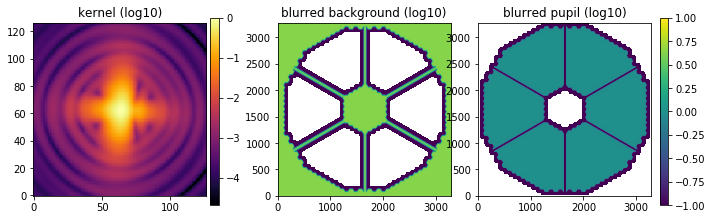

In [43]:
data = os.path.join(dir_data, 'IMG_VPM_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 1.31e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (4.95%, 5.66%)
optim 1 = 1e-05 (4.39%, 4.80%)
optim 2 = 1e-04 (3.60%, 3.57%)
optim 3 = 1e-03 (2.27%, 2.25%)
optim 4 = 1.31e-03 (2.10%, 2.03%)
optim 5 = 1e-02 (0.75%, 0.64%)


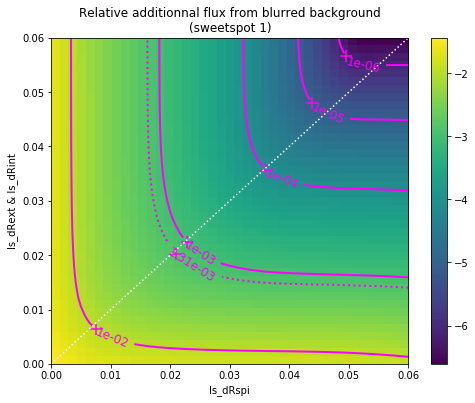

In [44]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 2.09e-02 (2.07%, 2.07%)
optim 0 = 1e-06 (1.17%, 0.90%)
optim 1 = 1e-05 (1.10%, 0.90%)
optim 2 = 1e-04 (0.62%, 0.47%)
optim 3 = 1e-03 (0.51%, 0.00%)
optim 4 = 1e-02 (0.22%, 0.00%)


/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in log10


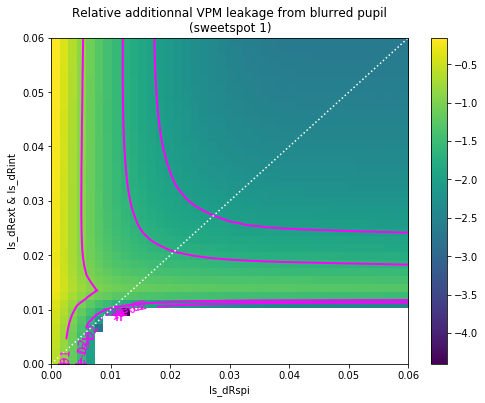

In [45]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 1.11e-03 (2.07%, 2.07%)
optim 0 = 1e-03 (0.90%, 2.97%)
optim 1 = 1.11e-03 (0.75%, 2.38%)


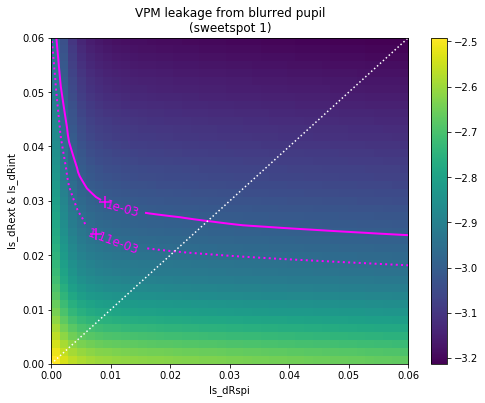

In [46]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_VPM_sweetspot2_pp1.txt

In [ ]:
data_i = 2
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 45, npup_vpm = 1193

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=4096, diam_norm=1.1342, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=1193, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil data from 'pup'
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519
   apply vortex phase mask
   2022-03-31 10:40:02, using 56 cores


In [ ]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

In [ ]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

In [ ]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_VPM_sweetspot3_pp1.txt

In [ ]:
data_i = 3
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

In [ ]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

In [ ]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

In [ ]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

# IMG 10.85" (L-band img classical + APP)

In [18]:
# 2D map
npup = 41
nspi = 41
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# optimal lyot stop params
rs_opt = 0.0391#0.0517
rp_opt = 0.0391#0.0491
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_10.85"',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'APP',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_10.85_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 45, npup_vpm = 1193



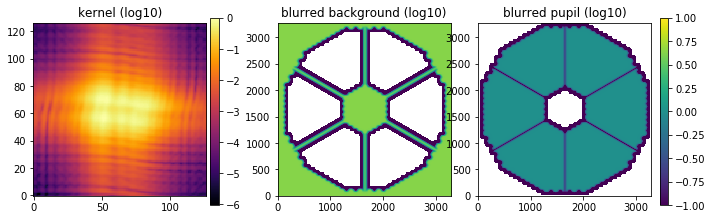

In [19]:
data = os.path.join(dir_data, 'IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 1.63e-05 (3.91%, 3.91%)
optim 0 = 1e-06 (4.19%, 5.10%)
optim 1 = 1e-05 (3.86%, 4.20%)
optim 2 = 1.63e-05 (3.75%, 4.01%)
optim 3 = 1e-04 (3.25%, 3.30%)
optim 4 = 1e-03 (2.13%, 2.25%)
optim 5 = 1e-02 (1.05%, 0.98%)


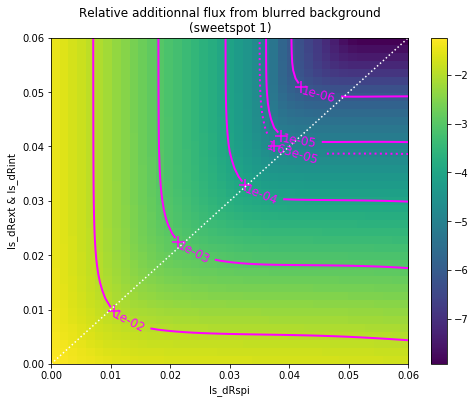

In [20]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 5.66e-03 (3.91%, 3.91%)
optim 0 = 1e-04 (4.01%, 5.40%)
optim 1 = 1e-03 (3.52%, 4.95%)
optim 2 = 5.66e-03 (2.85%, 3.91%)
optim 3 = 1e-02 (2.42%, 3.75%)
optim 4 = 1e-01 (1.49%, 2.25%)


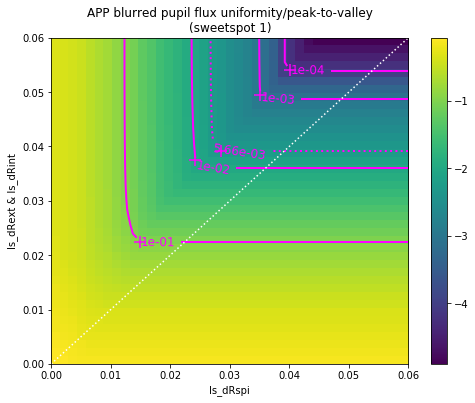

In [21]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_app%data_i)

### IMG_10.85_sweetspot2_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 45, npup_vpm = 1193



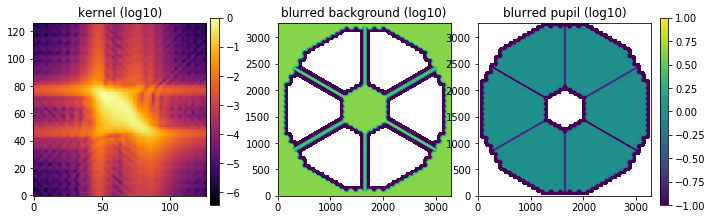

In [22]:
data_i = 2
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 1.29e-05 (3.91%, 3.91%)
optim 0 = 1e-06 (4.11%, 5.10%)
optim 1 = 1e-05 (3.75%, 4.19%)
optim 2 = 1.29e-05 (3.75%, 4.02%)
optim 3 = 1e-04 (3.15%, 3.19%)
optim 4 = 1e-03 (1.95%, 2.02%)
optim 5 = 1e-02 (0.78%, 0.75%)


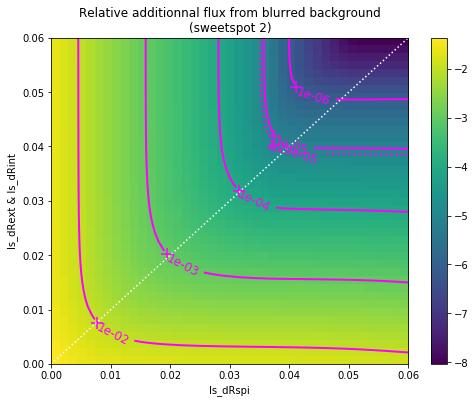

In [23]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 3.19e-03 (3.91%, 3.91%)
optim 0 = 1e-04 (4.06%, 5.70%)
optim 1 = 1e-03 (3.60%, 4.69%)
optim 2 = 3.19e-03 (3.15%, 3.92%)
optim 3 = 1e-02 (2.41%, 3.45%)
optim 4 = 1e-01 (1.20%, 2.30%)


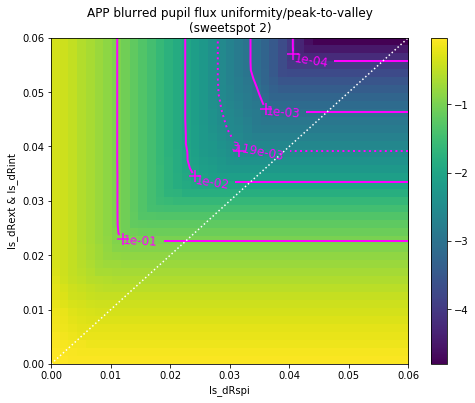

In [24]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_app%data_i)

### IMG_10.85_sweetspot3_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 45, npup_vpm = 1193



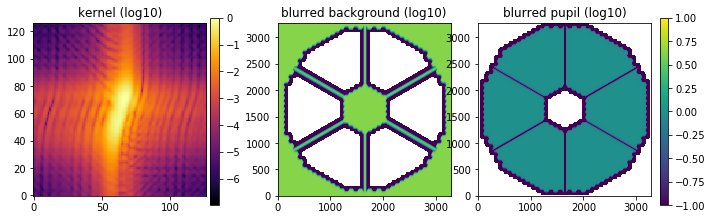

In [25]:
data_i = 3
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 9.91e-06 (3.91%, 3.91%)
optim 0 = 1e-06 (3.95%, 4.95%)
optim 1 = 9.91e-06 (3.66%, 4.05%)
optim 2 = 1e-05 (3.65%, 4.05%)
optim 3 = 1e-04 (3.00%, 3.15%)
optim 4 = 1e-03 (1.90%, 1.95%)
optim 5 = 1e-02 (0.75%, 0.64%)


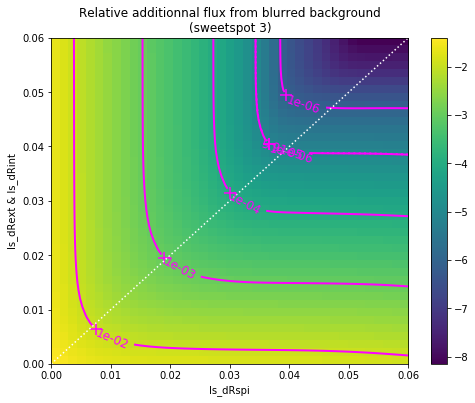

In [26]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 4.35e-03 (3.91%, 3.91%)
optim 0 = 1e-05 (4.50%, 5.89%)
optim 1 = 1e-04 (3.90%, 5.26%)
optim 2 = 1e-03 (3.30%, 4.75%)
optim 3 = 4.35e-03 (2.85%, 3.91%)
optim 4 = 1e-02 (2.35%, 3.45%)
optim 5 = 1e-01 (1.14%, 2.25%)


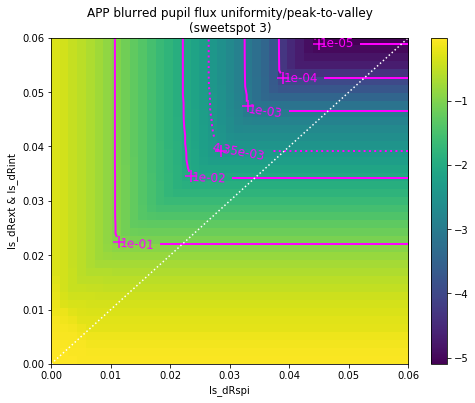

In [27]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_app%data_i)

# IMG 14" (N-band img classical + VPM)

In [28]:
# 2D map
npup = 41
nspi = 41
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# optimal lyot stop params
rs_opt = 0.0519#0.0645
rp_opt = 0.0519#0.0619
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_N_field_14"',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'N2',
        mode = 'CVC',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_14_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 19, npup_vpm = 497



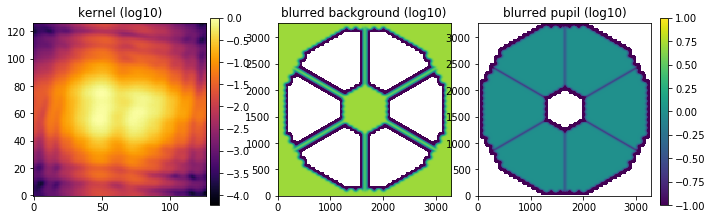

In [29]:
data = os.path.join(dir_data, 'IMG_14_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 2.70e-06 (5.19%, 5.19%)
optim 0 = 1e-06 (4.80%, 5.59%)
optim 1 = 2.70e-06 (4.55%, 5.40%)
optim 2 = 1e-05 (4.31%, 4.95%)
optim 3 = 1e-04 (3.75%, 4.02%)
optim 4 = 1e-03 (2.99%, 3.00%)
optim 5 = 1e-02 (1.80%, 1.63%)


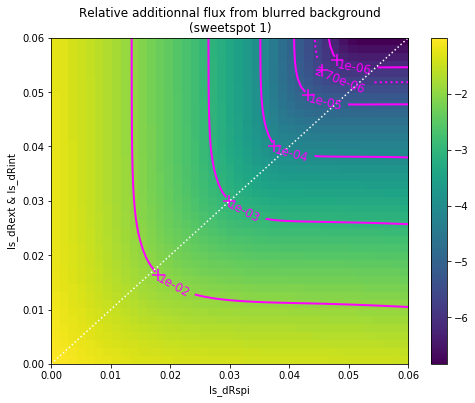

In [30]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 3.36e-03 (5.19%, 5.19%)
optim 0 = 3.36e-03 (4.95%, 4.19%)
optim 1 = 1e-02 (2.54%, 0.00%)
optim 2 = 1e-01 (0.65%, 0.00%)


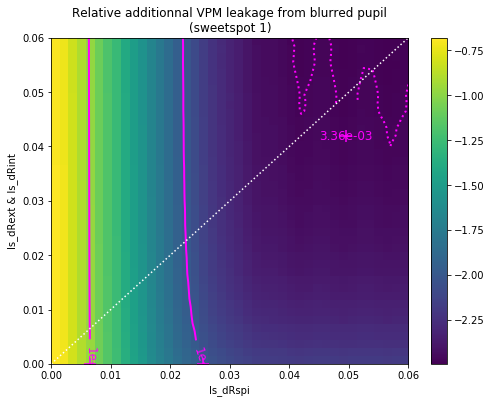

In [31]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 2.31e-02 (5.19%, 5.19%)
optim 0 = 2.31e-02 (6.00%, 0.94%)


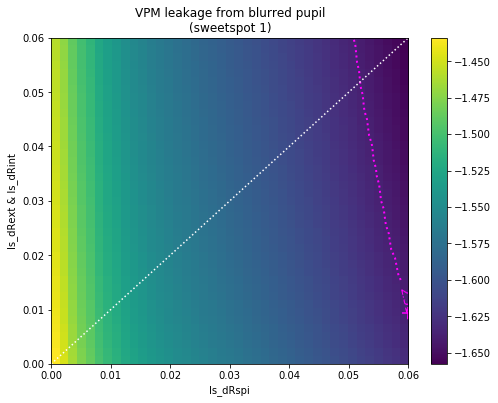

In [32]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_14_sweetspot2_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 19, npup_vpm = 497



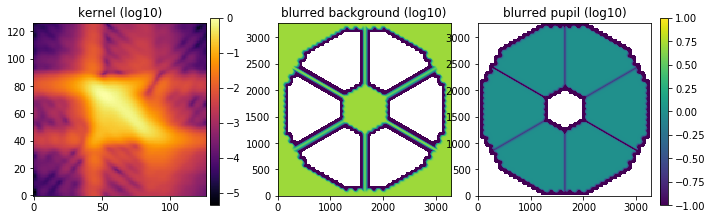

In [33]:
data_i = 2
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 1.97e-06 (5.19%, 5.19%)
optim 0 = 1e-06 (4.75%, 5.55%)
optim 1 = 1.97e-06 (4.58%, 5.40%)
optim 2 = 1e-05 (4.20%, 4.88%)
optim 3 = 1e-04 (3.60%, 3.90%)
optim 4 = 1e-03 (2.71%, 2.70%)
optim 5 = 1e-02 (1.35%, 1.28%)


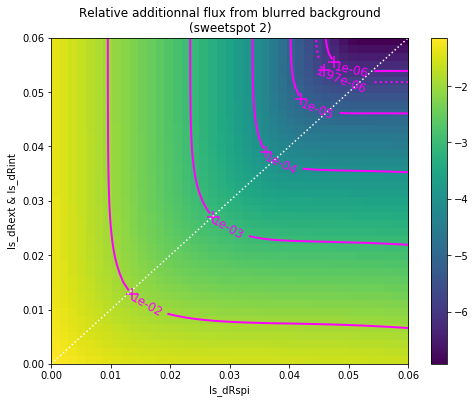

In [34]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 2.12e-03 (5.19%, 5.19%)
optim 0 = 2.12e-03 (4.95%, 3.71%)
optim 1 = 1e-02 (1.88%, 0.00%)
optim 2 = 1e-01 (0.29%, 0.00%)


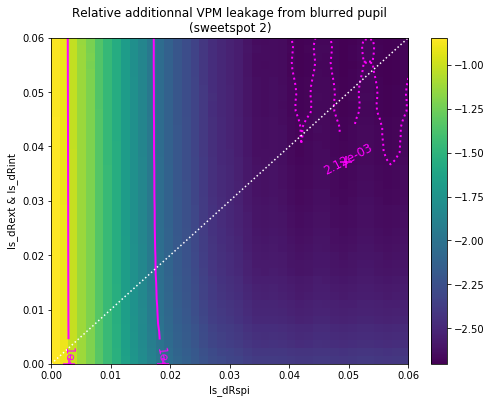

In [35]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 2.31e-02 (5.19%, 5.19%)
optim 0 = 2.31e-02 (6.00%, 0.88%)


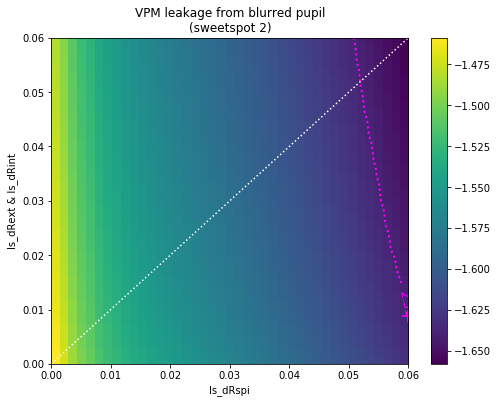

In [36]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_14_sweetspot3_pp1.txt

background:
   nkernel = 127, npup_conv = 3280 (IMG)
HCI:
   nkernel_vpm = 19, npup_vpm = 497



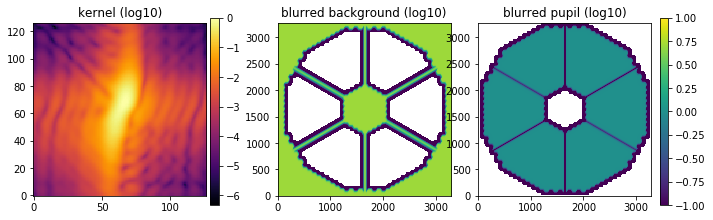

In [37]:
data_i = 3
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, pupil_img_size_scaled \
    = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp \
    = get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, 
                        kernel_vpm, pupil_img_size_scaled, data_i, rs, rp)

intersect = 8.02e-07 (5.19%, 5.19%)
optim 0 = 8.02e-07 (4.65%, 5.34%)
optim 1 = 1e-06 (4.63%, 5.25%)
optim 2 = 1e-05 (3.92%, 4.65%)
optim 3 = 1e-04 (3.45%, 3.62%)
optim 4 = 1e-03 (2.55%, 2.49%)
optim 5 = 1e-02 (1.18%, 1.05%)


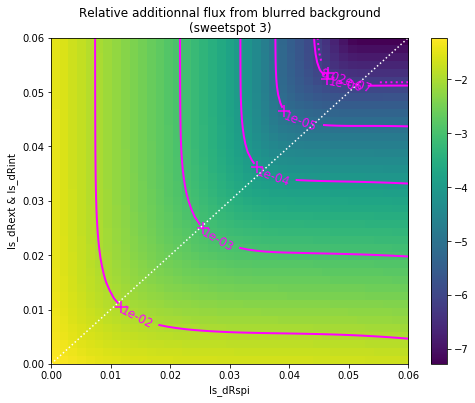

In [38]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 1.60e-03 (5.19%, 5.19%)
optim 0 = 1.60e-03 (5.70%, 3.21%)
optim 1 = 1e-02 (1.60%, 0.00%)
optim 2 = 1e-01 (0.10%, 0.00%)


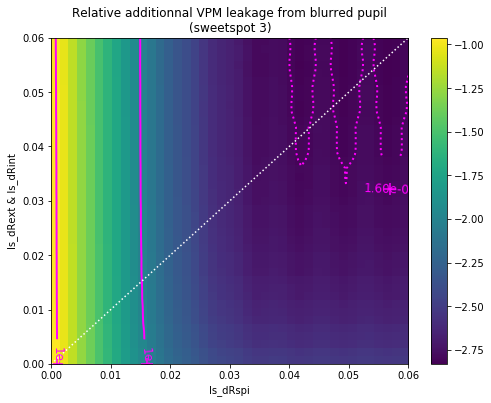

In [39]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 2.31e-02 (5.19%, 5.19%)
optim 0 = 2.31e-02 (6.00%, 0.86%)


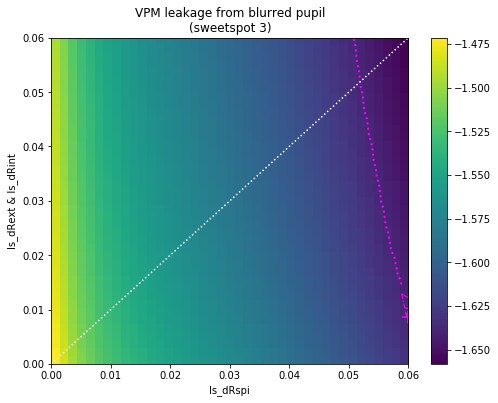

In [40]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)